In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from scipy.ndimage import zoom
import nibabel
import math
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Retrieve input data

In [11]:
data_dir = "/Users/zack/zack/deep_learning/gcp/"
X_train= np.load(data_dir+"train_img.npy")
train_age = np.load(data_dir+"train_age.npy")
train_sex = np.load(data_dir+"train_sex.npy")
Y_train = np.load(data_dir+"train_label.npy")

X_val = np.load(data_dir+"val_img.npy")
val_age = np.load(data_dir+"val_age.npy")
val_sex = np.load(data_dir+"val_sex.npy")
Y_val = np.load(data_dir+"val_label.npy")

In [12]:
# To keep it simple, we will take a training sample of 
# 50 normal and 50 AD MRI scans to run locally.

a = X_train[:50]
b = train_age[:50]
c = train_sex[:50]
d = Y_train[:50]

a = np.append(a,X_train[1050:1100])
b = np.append(b,train_age[1050:1100])
c = np.append(c,train_sex[1050:1100])
d = np.append(d,Y_train[1050:1100])

X_train = a
train_age = b
train_sex = c
Y_train = d

u,c = np.unique(Y_train, return_counts=True)
dict(zip(u,c))

{0.0: 50, 3.0: 50}

In [13]:
# We take 20 validation samples
X_val = X_val[118:138]
val_age = val_age[118:138]
val_sex = val_sex[118:138]
Y_val = Y_val[118:138]

u,c = np.unique(Y_val, return_counts=True)
dict(zip(u,c))

{0.0: 10, 3.0: 10}

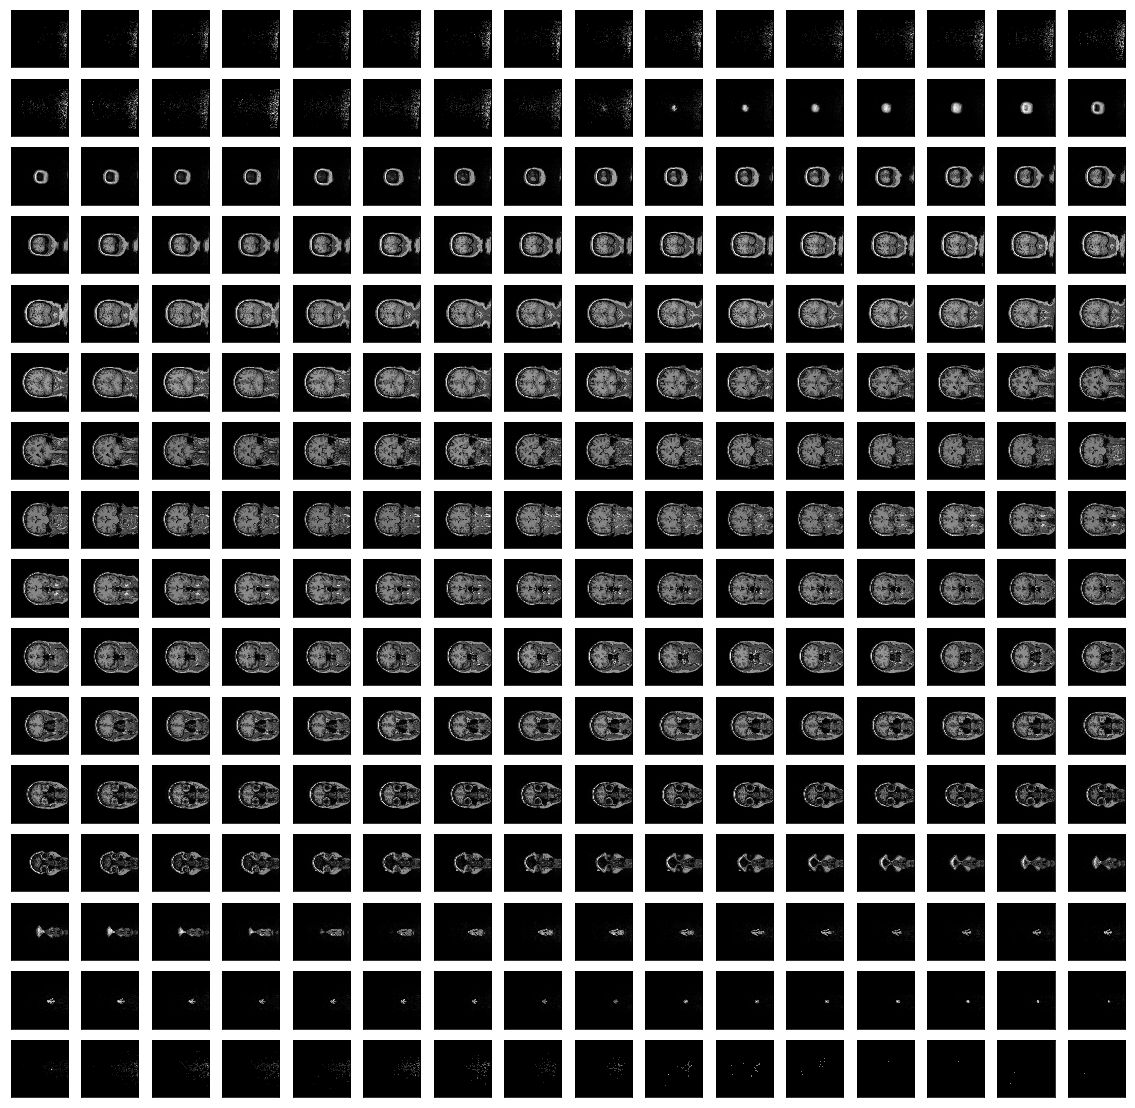

In [7]:
sample = X_train[0]
sample_data = nibabel.load(data_dir + sample).get_data()
fig, axes = plt.subplots(16,16, figsize=[20,20])

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_data[:, :, i], 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title('Slice number: {}'.format(slice), color='r')
#fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [8]:
#one hot encoding of labels
Y_train = np.eye(6)[Y_train.astype(int)]
Y_val = np.eye(6)[Y_val.astype(int)]

#add a new axis to age and sex
X_train = X_train.reshape(-1,1)
train_age = train_age.reshape(-1,1)
train_sex = train_sex.reshape(-1,1)

val_age = val_age.reshape(-1,1)
val_sex = val_sex.reshape(-1,1)


#define function to retrieve images from image paths
def get_img(minibatch_X):
    X = np.zeros((1,128,128,128))
    
    for img in minibatch_X:
        X = np.append(X,zoom(nibabel.load(data_dir + img).get_data(),(0.5, 0.5, 0.5))[np.newaxis,:],axis=0)
    
    #get rid of the first zero 
    X = X[1:]
    
    X /= 255
    X = X[:,:,:,:,np.newaxis]
    
    return X

In [9]:
# get img data for val since val is not very big and we need them
# all to get test accuracy
X_val = get_img(X_val)

print(X_train.shape,train_age.shape,train_sex.shape,Y_train.shape)
print(X_val.shape,val_age.shape,val_sex.shape,Y_val.shape)

(100, 1) (100, 1) (100, 1) (100, 6)
(20, 128, 128, 128, 1) (20, 1) (20, 1) (20, 6)


# Model

In [118]:
def create_placeholders(n_M0 = 128, n_H0 = 128, n_W0 = 128, n_C0 = 1, n_y = 6 ):#create placeholders for X Y AGE SEX
    """
    Arguments:
    n_M0 -- scalar, how many image one second
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
    """
    X = tf.placeholder(tf.float32, shape=(None,n_M0,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    age = tf.placeholder(tf.float32, shape=(None,1))
    sex = tf.placeholder(tf.float32, shape=(None,1))
    return X, Y, age, sex

def initialize_parameters():
    
    tf.set_random_seed(1)
    W1 = tf.get_variable('W1',[4,4,4,1,8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[2,2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

def forward_propagation(X,age,sex, parameters):
    """
    Implements the forward propagation for the model:
    CONV3D -> RELU -> MAXPOOL -> CONV3D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z4 -- the output of the last LINEAR unit
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    # CONV2D: stride of 2, padding 'SAME'
    Z1 = tf.nn.conv3d(X,W1, strides = [1,2,2,2,1], padding = 'VALID')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool3d(A1, ksize = [1,8,8,8,1], strides = [1,8,8,8,1], padding = 'VALID')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv3d(P1,W2, strides = [1,2,2,2,1], padding='VALID')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool3d(A2, ksize = [1,4,4,4,1], strides=[1,4,4,4,1], padding='VALID')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    #Add age and sex into p3 layer
    age  = tf.layers.Flatten()(age)
    sex = tf.layers.Flatten()(sex)
    P3 = tf.concat([P2,age,sex],1)
    
    # FULLY-CONNECTED without non-linear activation function (not call softmax).
    P3 = tf.layers.dense(inputs=P3, units=30, activation=tf.nn.relu)
    
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z4 = tf.contrib.layers.fully_connected(P3, num_outputs = 6,activation_fn=None)
    
    return Z4

def compute_cost(Z4, Y):
    """
    Computes the cost
    
    Arguments:
    Z4 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z4
    
    Returns:
    cost - Tensor of the cost function
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = Y))
    return cost

def random_mini_batches(X, Y,age,sex, mini_batch_size = 3, seed = 0):
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y,age,sex)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]
    shuffled_age = age[permutation,:]
    shuffled_sex = sex[permutation,:]
    
    # Step 2: Partition (shuffled_X, shuffled_Y,shuffled_age,shuffled_sex). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X =  shuffled_X[mini_batch_size * k : (k+1) * mini_batch_size,:]
        mini_batch_Y = shuffled_Y[mini_batch_size * k : (k+1) * mini_batch_size,:]
        mini_batch_age = shuffled_age[mini_batch_size * k : (k+1) * mini_batch_size,:]
        mini_batch_sex = shuffled_sex[mini_batch_size * k : (k+1) * mini_batch_size,:]
        
        mini_batch = (mini_batch_X, mini_batch_Y, mini_batch_age,mini_batch_sex)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : ,: ]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : ,:]
        mini_batch_age = shuffled_age[num_complete_minibatches * mini_batch_size : ,: ]
        mini_batch_sex = shuffled_sex[num_complete_minibatches * mini_batch_size : ,: ]
        
        mini_batch = (mini_batch_X, mini_batch_Y, mini_batch_age, mini_batch_sex)
        mini_batches.append(mini_batch)
    
    return mini_batches

epoch_traccuracy=[]
epoch_vlaccuracy=[]

def model(X_train, Y_train, train_age, train_sex, pretrained = False,
          learning_rate = 0.01, num_epochs = 3, minibatch_size = 10, print_cost = True):
    ops.reset_default_graph()                         
    
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    #(m,n_M0, n_H0, n_W0, n_C0) = X_train.shape 
    m = X_train.shape[0]
    #n_y = Y_train.shape[1]
    costs = []
    
    #X, Y, age, sex = create_placeholders(n_M0=n_M0, n_H0=n_H0, n_W0=n_W0, n_C0=n_C0, n_y=n_y)
    X, Y, age, sex = create_placeholders()
    
    parameters = initialize_parameters()
    Z4 = forward_propagation(X,age,sex, parameters)
    cost = compute_cost(Z4, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    #accuracy
    predict_op = tf.argmax(Z4, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    saver = tf.train.Saver()
    best_val_acc = float('Inf')
    
    with tf.Session() as sess:
        sess.run(init)
        
        if pretrained is True:
            saver.restore(sess, "./model.ckpt")
            print("Model restored.")
        
        for epoch in range(num_epochs):
            train_accuracy = 0
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train,train_age,train_sex, minibatch_size, seed)
            
            
            for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y, mini_batch_age,mini_batch_sex) = minibatch
                minibatch_X =  [j for i in minibatch_X for j in i]
                
                
                minibatch_X = get_img(minibatch_X)
                _ , temp_cost = sess.run(optimizer,feed_dict={X:minibatch_X,Y:minibatch_Y,age:mini_batch_age,sex:mini_batch_sex}),sess.run(cost,feed_dict={X:minibatch_X,Y:minibatch_Y,age:mini_batch_age,sex:mini_batch_sex})
                minibatch_cost += temp_cost / num_minibatches
                
                train_accuracy += accuracy.eval({X:minibatch_X , Y: minibatch_Y, age: mini_batch_age, sex: mini_batch_sex})/num_minibatches
                
                del minibatch_X
            
            if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
            
            print("Train Accuracy:",train_accuracy)
            #calculate test_accuracy 
            test_accuracy = accuracy.eval({X: X_val, Y: Y_val, age: val_age, sex: val_sex})
            print("Test Accuracy:", test_accuracy)
            
            epoch_traccuracy.append(train_accuracy)
            epoch_vlaccuracy.append(test_accuracy)
            
            if test_accuracy <= best_val_acc:
                save_path = saver.save(sess, "./model.ckpt")
                print("Model saved in path: %s" % save_path)
                best_val_acc = test_accuracy
        
        
        return accuracy, parameters

Cost after epoch 0: 0.834014


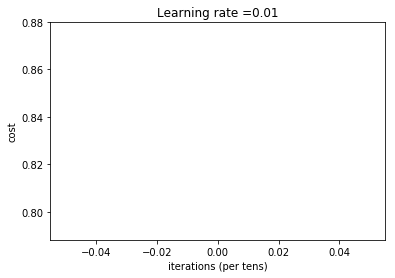

Train Accuracy: 0.5800000071525574
Test Accuracy: 0.5
Model saved in path: ./model.ckpt
Cost after epoch 1: 0.660971


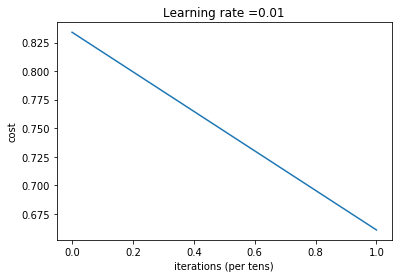

Train Accuracy: 0.6100000023841858
Test Accuracy: 0.5
Model saved in path: ./model.ckpt
Cost after epoch 2: 0.595364


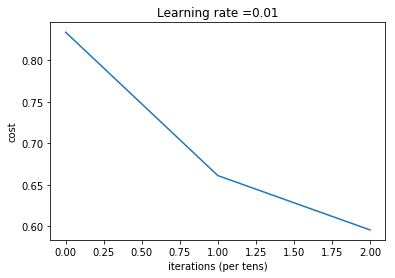

Train Accuracy: 0.7100000053644181
Test Accuracy: 0.55


In [119]:
accuracy, parameters = model(X_train, Y_train, train_age, train_sex)